# Optimization Mini-Project

Importing Libraries

In [1]:
import scipy.optimize as opt
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import numdifftools as nd
import pandas as pd

%matplotlib notebook

## Part I: Numerical Unconstrained Optimization Techniques

You should write a program to compare the performance of the following methods:
1. Univariate search method
2. Powell's method
3. Gradient descent method (once with fixed step size and another with optimal step size)

from the viewpoints of time required (or number of function evaluations) and quality of solutions obtained for each of the following benchmark functions:
* De Jong’s function in 2D
* Rosenbrock’s valley in 2D
* Rastrigin’s function in 2D
* 4-Easom’s function
* Branins’s function

Plot the function in 3-D and locate the result on the graph to visualize to what extent your result matches the correct answer and to detect whether you are trapped in a local minimum or not. Moreover, you should investigate the effect of changing the initial guess on the quality of solution as well as time needed.

### The Benchmark Functions

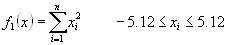

In [2]:
def de_jong(x, *args):
    x1, x2 = x
    return np.square(x1) + np.square(x2)

In [3]:
def rosenbrock(x):
    x1, x2 = x
    a = 1
    b = 100
    return np.square(a - x1) + b * np.square(x2 - np.square(x1))

In [4]:
def rastrigin(x):
    x1, x2 = x
    return 10 * 2 + (np.square(x1) - 10 * np.cos(2 * np.pi * x1)) + (np.square(x2) - 10 * np.cos(2 * np.pi * x2))

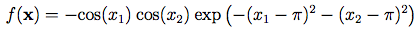

In [5]:
def easom(x):
    x1, x2 = x
    return -np.cos(x1) * np.cos(x2) * np.exp(-np.square(x1 - np.pi) - np.square(x2 - np.pi))

In [6]:
def brainin(x, *args):
    PI = np.pi
    a = 1
    b = 5.1 / (4 * PI**2)
    c = 5 / PI
    r = 6
    s = 10
    t = 1 / (8 * PI)
    x1, x2 = x
    return a * (x2 - b * x1 ** 2 + c * x1 - r) ** 2 + s * (1 - t) * np.cos(x1) + s

### The Optimization Methods

**Univariate Search Method**

In [7]:
def univariate_search(objective_function, x0, epsilon=0.01):
    s = np.array([[1, 0], [0, 1]])
    i = 0
    x = np.array(x0)
    final_res = {}
    final_res['nfev'] = 0
    while True:
        f = objective_function(x)
        f_plus = objective_function(x + epsilon * s[i%2])
        f_minus = objective_function(x - epsilon * s[i%2])
        if f_minus > f and f_plus > f:
            return final_res
        elif f_plus < f and f_minus > f:
            result = opt.line_search(objective_function, nd.Gradient(objective_function), x, s[i%2])
            S = s[i%2]
        elif f_minus < f and f_plus > f:
            result = opt.line_search(objective_function, nd.Gradient(objective_function), x, -s[i%2])
            S = -s[i%2]
        res = {}
        lambda_, res['fc'], res['gc'], res['new_fval'], res['old_fval'], res['new_slope'] = result
        x = x + lambda_ * S
        final_res['x'] = x
        final_res['nfev'] += res['fc'] + res['gc']
        final_res['fun'] = res['new_fval']
        i += 1

**Gradient Descent w/ Fixed Step**

In [8]:
def gradient_descent(J_grad, x_init, alpha=0.01, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        x = x - alpha * J_grad(x)
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

**Gradient Descent w/ Optimal Step**

In [9]:
def goldenSearch(f, a, b, tol=1e-7):
    phi = (np.sqrt(5) + 1) / 2
    d = b - (b - a) / phi
    c = a + (b - a) / phi
    while abs(d - c) > tol:
        if f(d) < f(c):
            b = c
        else:
            a = d
        d = b - (b - a) / phi
        c = a + (b - a) / phi
    return (a + b) / 2

In [10]:
def gradient_descent_optimal(J, J_grad, x_init, epsilon=1e-10, max_iterations=1000):
    x = x_init
    for i in range(max_iterations):
        def q(alpha): return J(x - alpha * J_grad(x))
        alpha = goldenSearch(q, 0, 1)
        x = x - alpha * J_grad(x)
        if np.linalg.norm(J_grad(x)) < epsilon:
            return x, i + 1
    return x, max_iterations

### Auxiliary Functions

**Performance Evaluation Function**

In [11]:
def evaluate_performance(objective_function, x, method):
    results = {}
    start_time = time.time_ns()
    if method == 'univariate_search':
        results = univariate_search(objective_function, x0=x)
    elif method == 'powell':
        results = opt.minimize(objective_function, x0=x, method='Powell')
    elif method == 'gradient_descent':
        results['x'], it = gradient_descent(nd.Gradient(objective_function), x)
    elif method == 'gradient_descent_optimal':
        results['x'], it = gradient_descent_optimal(objective_function, nd.Gradient(objective_function), x)
    total_time = time.time_ns() - start_time
    results = dict(results)
    results['time_taken_ms'] = total_time/1e6
    return results

**3D Plot Function**

Black point: initial x

<span style="color:green">Green</span> point: final x

In [12]:
def plot_3d(x, final_x, func):
    x1, x2 = x
    X, Y = np.meshgrid(np.linspace(-6, 6, 30), np.linspace(-6, 6, 30))
    Z = func((X, Y))
    fig = plt.figure(figsize=(4,4))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, edgecolor='none')
    ax.scatter(x1, x2, func(x), s=50, color='black')
    ax.scatter(final_x[0], final_x[1], func(final_x), s=50, color='green')
    ax.set_xlabel('x'), ax.set_ylabel('y'), ax.set_zlabel('z')

### Running the tests...

Initializations

In [26]:
objective_functions = [de_jong, rosenbrock, rastrigin, easom, brainin]
x1 = random.uniform(-6, 6)
x2 = random.uniform(-6, 6)
x = (x1, x2)
tabulated_results = dict.fromkeys(['univariate_search', 'powell', 'gradient_descent', 'gradient_descent_optimal'])

Univariate Search

<function de_jong at 0x000001D4C838B700>


<IPython.core.display.Javascript object>


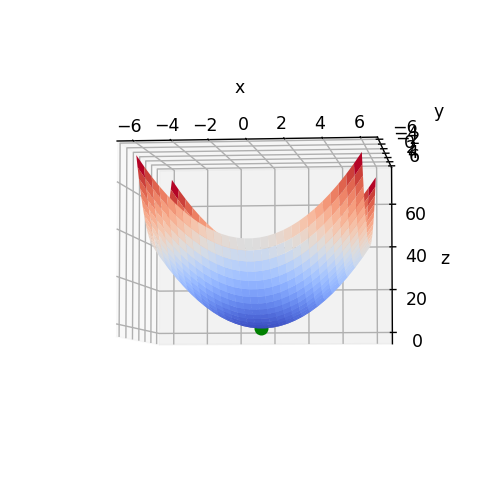

<function rosenbrock at 0x000001D4CCDC91F0>


<IPython.core.display.Javascript object>


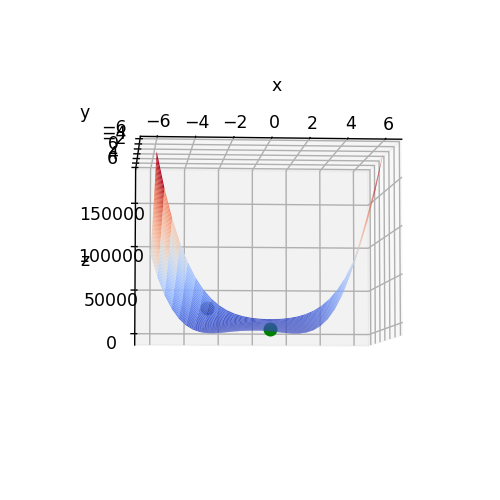

<function rastrigin at 0x000001D4CCDC94C0>


<IPython.core.display.Javascript object>


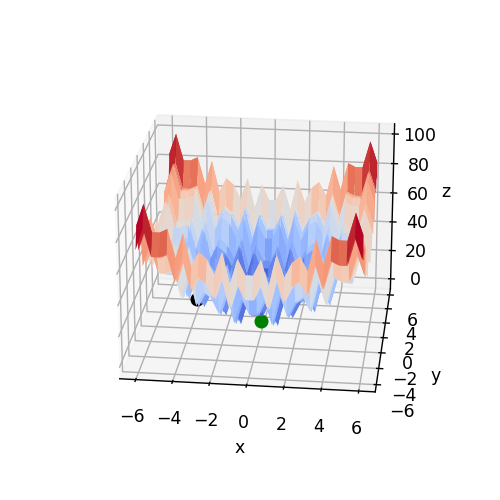

<function easom at 0x000001D4CCDC9940>


<IPython.core.display.Javascript object>


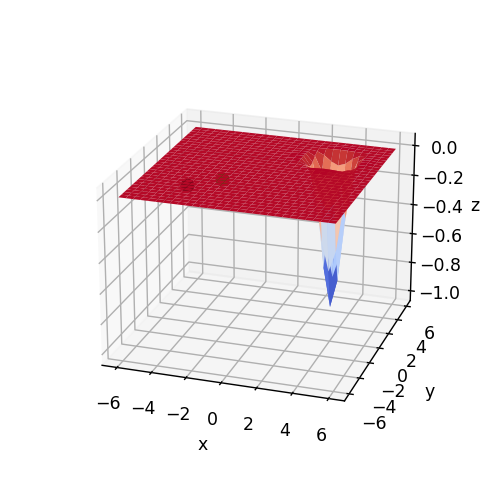

<function brainin at 0x000001D4CCDC9700>


<IPython.core.display.Javascript object>


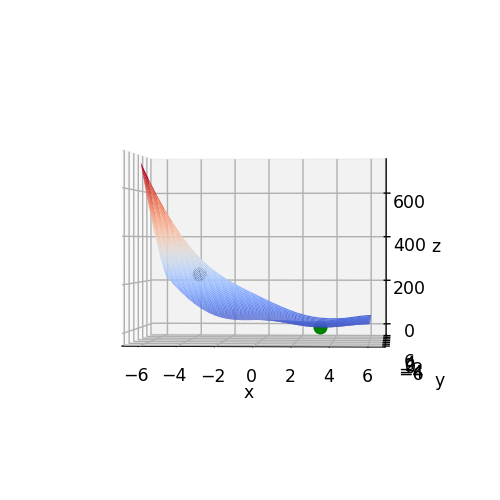

In [27]:
tabulated_results['univariate_search'] = {}
for of in objective_functions:
    results = evaluate_performance(of, x, 'univariate_search')
    tabulated_results['univariate_search'][of.__name__] = results
    print(of)
    plot_3d(x, results['x'], of)

Powell method

<IPython.core.display.Javascript object>


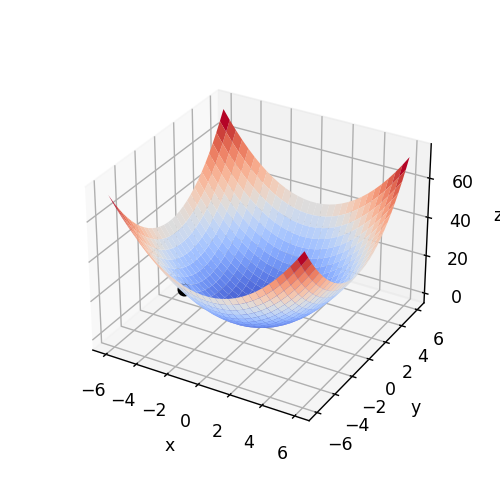

<IPython.core.display.Javascript object>


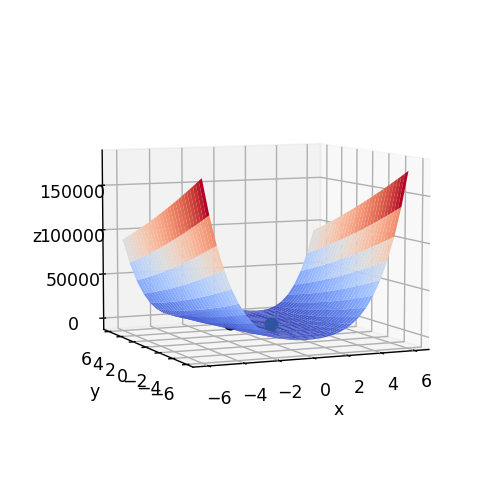

<IPython.core.display.Javascript object>


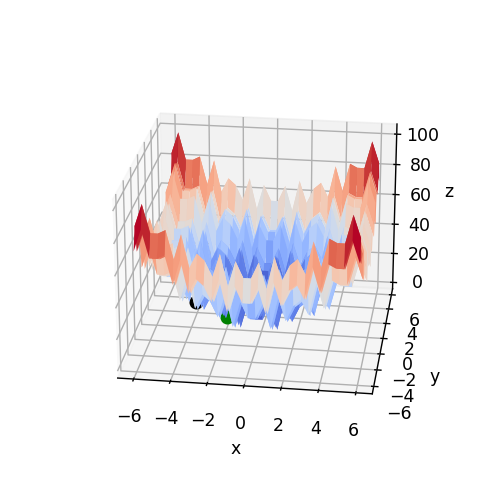

<IPython.core.display.Javascript object>


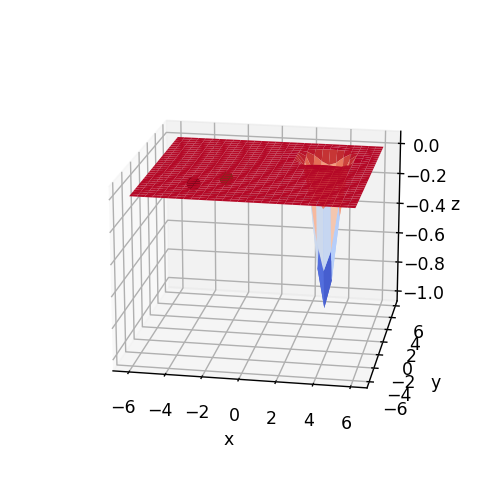

<IPython.core.display.Javascript object>


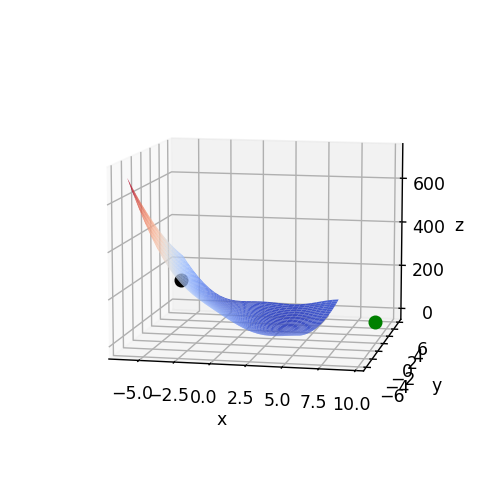

In [28]:
tabulated_results['powell'] = {}
for of in objective_functions:
    results = evaluate_performance(of, x, 'powell')
    tabulated_results['powell'][of.__name__] = results
    plot_3d(x, results['x'], of)

Gradient Descent with Fixed Step

<IPython.core.display.Javascript object>


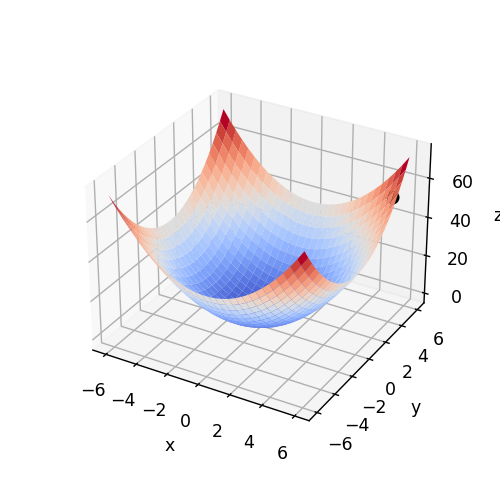

<IPython.core.display.Javascript object>


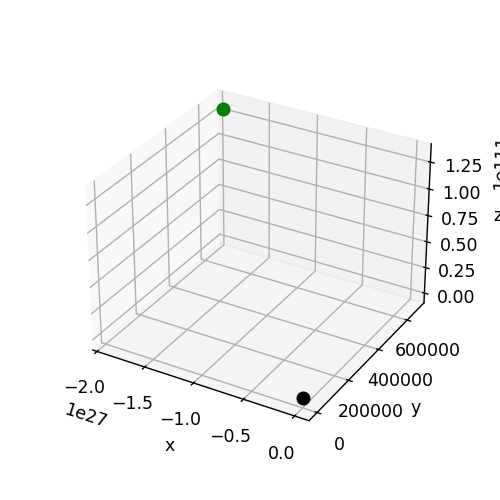

<IPython.core.display.Javascript object>


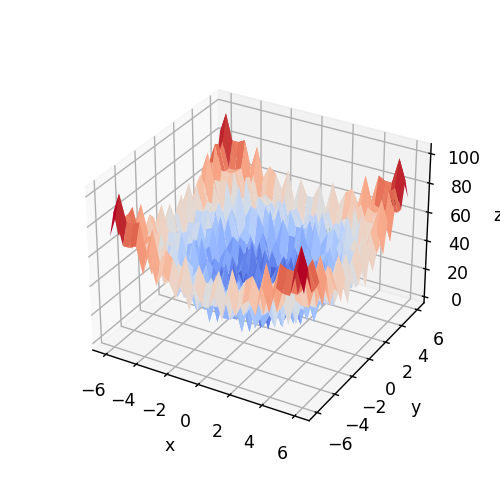

<IPython.core.display.Javascript object>


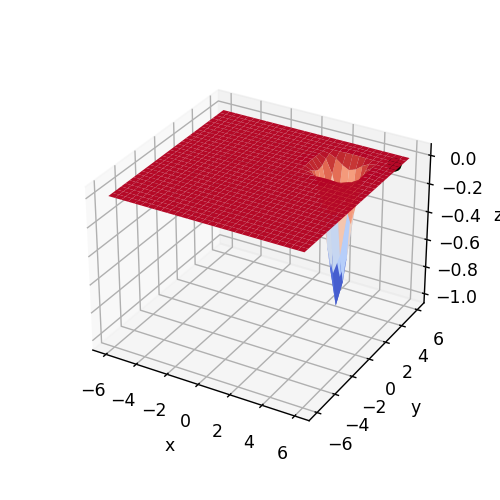

<IPython.core.display.Javascript object>


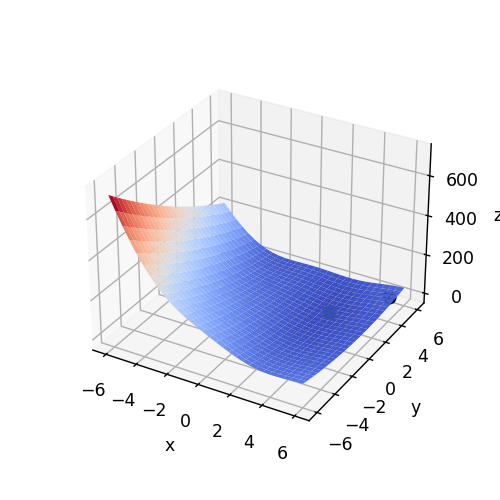

In [16]:
tabulated_results['gradient_descent'] = {}
for of in objective_functions:
    results = evaluate_performance(of, x, 'gradient_descent')
    tabulated_results['gradient_descent'][of.__name__] = results
    plot_3d(x, results['x'], of)

Gradient Descent with Optimal Step

<IPython.core.display.Javascript object>


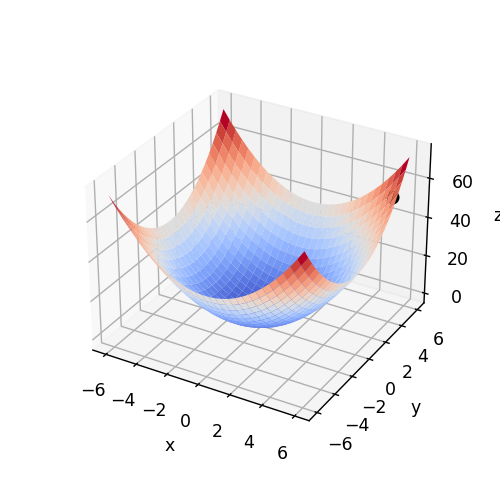

<IPython.core.display.Javascript object>


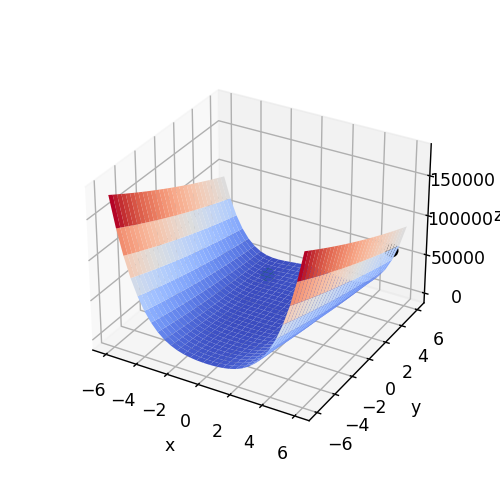

<IPython.core.display.Javascript object>


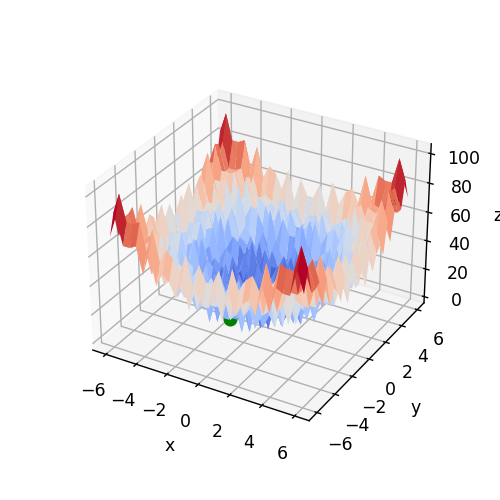

<IPython.core.display.Javascript object>


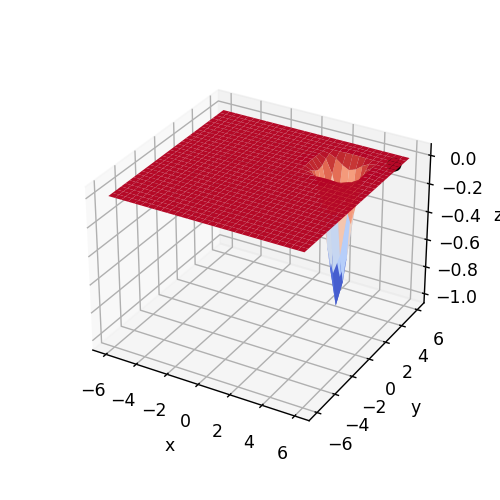

<IPython.core.display.Javascript object>


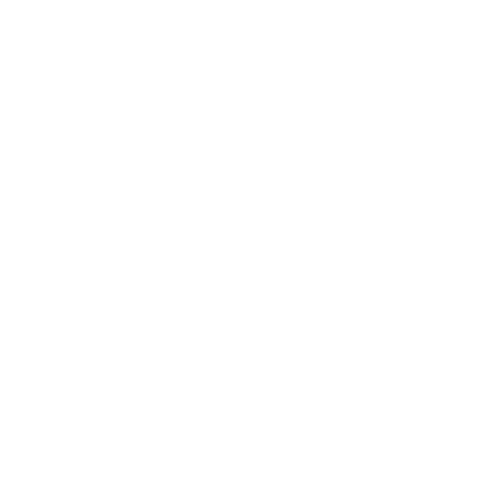

In [17]:
tabulated_results['gradient_descent_optimal'] = {}
for of in objective_functions:
    results = evaluate_performance(of, x, 'gradient_descent_optimal')
    tabulated_results['gradient_descent_optimal'][of.__name__] = results
    plot_3d(x, results['x'], of)

Comparison of Methods' Performances

In [18]:
tr = tabulated_results.copy()

In [19]:
tr['univariate_search'] = pd.DataFrame.from_dict(tr['univariate_search'])
tr['powell'] = pd.DataFrame.from_dict(tr['powell'])
tr['gradient_descent'] = pd.DataFrame.from_dict(tr['gradient_descent'])
tr['gradient_descent_optimal'] = pd.DataFrame.from_dict(tr['gradient_descent_optimal'])

In [20]:
tr['univariate_search']

,de_jong,rosenbrock,rastrigin,easom,brainin
nfev,41,33,18,34,61
x,"[-5.551115123125783e-17, -4.163336342344337e-17]","[2.620827359555794, 6.868736048596194]","[5.969461658609956, 4.978724046724725]","[4.978070186880601, 4.982134239292386]","[3.142471480653961, 2.274314738384206]"
fun,0.0,2.627081,60.694907,-0.000081,0.397891
time_taken_ms,71.2798,34.3805,15.5824,53.4712,132.1951


In [21]:
tr['powell']

,de_jong,rosenbrock,rastrigin,easom,brainin
fun,0.0,0.0,25.868682,-0.000081,0.397887
direc,"[[1.0, 0.0], [0.0, 1.0]]","[[-0.04207964374318686, -0.08263560560456493],...","[[-0.0023024253477021027, 3.8547976780854174e-...","[[1.0, 0.0], [0.0, 1.0]]","[[0.0, 1.0], [0.054218411056628474, -0.0457725..."
nit,2,19,4,2,3
nfev,38,573,136,55,69
status,0,0,0,0,0
success,True,True,True,True,True
message,Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully.,Optimization terminated successfully.
x,"[-6.217248937900877e-15, -5.329070518200751e-15]","[0.9999999999999987, 0.9999999999999973]","[0.9949586405991834, 4.97469138815928]","[4.97818694969321, 4.978190157875184]","[3.141592761641675, 2.274988080658314]"
time_taken_ms,2.8813,28.5289,8.8507,2.9987,5.3822


In [22]:
tr['gradient_descent']

,de_jong,rosenbrock,rastrigin,easom,brainin
x,"[9.390066964318123e-09, 8.225664991958932e-09]","[-1.9063515065276165e+27, 673202.0622576943]","[2.587598026742004, 3.3210205381361266]","[5.578803739378646, 4.88795256720269]","[3.141592644978912, 2.275000050163087]"
time_taken_ms,5985.197,20.5839,8297.9163,10399.7918,8687.447


In [23]:
tr['gradient_descent_optimal']

,de_jong,rosenbrock,rastrigin,easom,brainin
x,"[-2.351711287187398e-13, -2.0600907035254643e-13]","[-2.0568618279164683, 4.238371960839252]","[-0.9275211762052531, -1.8693312583659307]","[5.5027524788082, 4.919454770612046]","[3.1415926641264913, 2.275000001808707]"
time_taken_ms,555.3731,262439.4342,301503.7486,344441.9569,265951.7875
